### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import geoplot.crs as gcrs
import geoplot as gplt
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

### Loading data

In [2]:
import pandas as pd
df_l = pd.read_csv('data/listings.csv', low_memory=False)
df_geo = gpd.read_file('data/neighbourhoods.geojson')

In [3]:
df_l.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,gmaps_result,centre_transit_time
0,23163,https://www.airbnb.com/rooms/23163,20200229181007,2020-03-01,"Quiet 1BR directly in the Centre, Air-conditio...","Unique and elegant apartment rental in Prague,...",Unique and elegant apartment rental in Prague ...,"Unique and elegant apartment rental in Prague,...",none,Check my guidebook for this apartment to disco...,"To help you with your first steps in Prague, I...",The closest METRO station is called „Narodni t...,NaN,"Of course, you can contact me anytime during y...",Thank you for treating the property like it wa...,NaN,NaN,https://a0.muscache.com/im/pictures/01bbe32c-3...,NaN,5282,https://www.airbnb.com/users/show/5282,Klara,2008-12-17,"Prague, Prague, Czech Republic","Hello, \r\nglad to see that you are interested...",within an hour,97%,100%,t,https://a0.muscache.com/im/pictures/user/b7309...,https://a0.muscache.com/im/pictures/user/b7309...,Josefov,69.0,69.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Prague, Czech Republic, Czech Republic",Staré Město,Praha 1,NaN,Prague,Czech Republic,11000,Prague,"Prague, Czech Republic",CZ,Czech Republic,50.08229,14.41552,t,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",775.0,"$3,717.00",NaN,NaN,"$2,546.00",NaN,2,$636.00,1,365,1,7,365,365,5.6,365.0,today,t,19,40,70,288,2020-03-01,19,3,2010-09-20,2019-07-27,98.0,9.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,moderate,f,f,69,68,0,0,0.17,{'destination_addresses': ['Staroměstské nám. ...,9.883333


In [4]:
cols_to_drop = 'listing_url	scrape_id	last_scraped	name	summary	space	description	experiences_offered	neighborhood_overview	notes	transit	access	interaction	house_rules	thumbnail_url	medium_url	picture_url	xl_picture_url	host_url	host_name	host_location	host_about	host_thumbnail_url	host_picture_url	host_neighbourhood	host_listings_count	host_verifications	street	neighbourhood	neighbourhood_group_cleansed	city	state	zipcode	market	smart_location	country_code	country	latitude	longitude	is_location_exact	square_feet	weekly_price	monthly_price	maximum_nights	calendar_updated	has_availability	availability_30	availability_60	availability_90	availability_365	calendar_last_scraped	first_review	last_review	jurisdiction_names	require_guest_profile_picture	require_guest_phone_verification	calculated_host_listings_count	license	gmaps_result'.split('\t')

In [5]:
df_lf = df_l.drop(cols_to_drop, axis = 1)

In [6]:
def convert_prices(df, cols):
    for col in cols:
        df[col] = df[col].str.replace('[$|,]', '').astype(float)
    return df

In [7]:
money_cols = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']

In [8]:
df_lf = convert_prices(df_lf, money_cols)

In [9]:
df_lf.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,centre_transit_time
0,23163,5282,2008-12-17,within an hour,97%,100%,t,69.0,t,t,Praha 1,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",3717.0,2546.0,NaN,2,636.0,1,1,7,365,365,5.6,365.0,19,3,98.0,9.0,10.0,10.0,10.0,10.0,10.0,f,t,f,moderate,68,0,0,0.17,9.883333
1,23169,5282,2008-12-17,within an hour,97%,100%,t,69.0,t,t,Praha 1,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Pets allowed"",Eleva...",2493.0,2546.0,NaN,2,636.0,1,1,7,365,365,1.2,365.0,113,1,95.0,10.0,10.0,10.0,10.0,10.0,9.0,f,t,f,moderate,68,0,0,0.95,4.766667
2,26748,113902,2010-04-26,within an hour,100%,100%,t,3.0,t,t,Praha 7,Apartment,Entire home/apt,6,1.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",2540.0,5092.0,458.0,4,255.0,3,2,7,1125,1125,3.2,1125.0,345,54,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,t,f,moderate,3,0,0,3.00,16.900000
3,26755,113902,2010-04-26,within an hour,100%,100%,t,3.0,t,t,Praha 1,Apartment,Entire home/apt,4,1.5,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",2032.0,3819.0,458.0,3,204.0,3,2,7,1125,1125,3.2,1125.0,246,53,99.0,10.0,10.0,10.0,10.0,10.0,10.0,f,t,f,moderate,3,0,0,4.22,13.450000
4,27916,120384,2010-05-08,within an hour,100%,100%,t,3.0,t,t,Praha 3,Condominium,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Paid par...",1039.0,0.0,350.0,1,0.0,2,2,2,50,50,2.0,50.0,411,48,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,t,f,moderate,3,0,0,3.52,20.683333


In [10]:
counts = df_l.groupby('neighbourhood_cleansed', as_index = False)['id'].count()

In [11]:
counts['ratio'] = counts['id'] /  df_l.shape[0]

In [12]:
counts.columns = ['neighbourhood', 'count', 'ratio']

In [13]:
df_geo = df_geo.merge(counts, on = 'neighbourhood', how= 'left')

In [14]:
df_geo['coords'] = df_geo['geometry'].apply(lambda x: x.centroid)

In [15]:
points_df = df_geo[['neighbourhood', 'coords']]

In [16]:
points_df.columns = ['name', 'geometry']
df_p = gpd.GeoDataFrame(points_df)

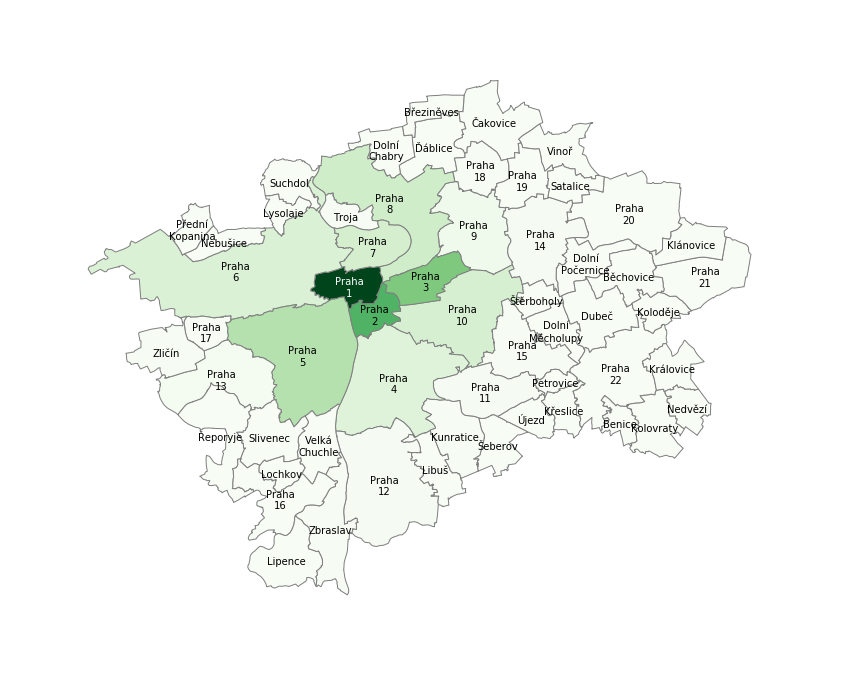

In [39]:
ax = gplt.choropleth(df_geo, 
                     projection=gcrs.EuroPP(),
                     hue = df_geo['ratio'],
                     cmap = 'Greens',
                     edgecolor='grey', linewidth=1,
                     figsize=(15, 15))
for i, item in df_geo.to_crs('EPSG:25832').centroid.iteritems():
        ax.annotate(s=df_geo.iloc[i]['neighbourhood'].replace(' ', '\n'), 
            xy=[item.x, item.y], 
            color= 'black' if not (df_geo.iloc[i]['neighbourhood'] == 'Praha 1') else 'white', 
            horizontalalignment='center',
            verticalalignment='center')

In [18]:
points = gpd.GeoDataFrame(
    df_l, geometry=gpd.points_from_xy(df_l.longitude, df_l.latitude))

/opt/conda/lib/python3.7/site-packages/geoplot/geoplot.py:625: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  extent = gpd.GeoSeries(self.extent) if self.extent is not None else None


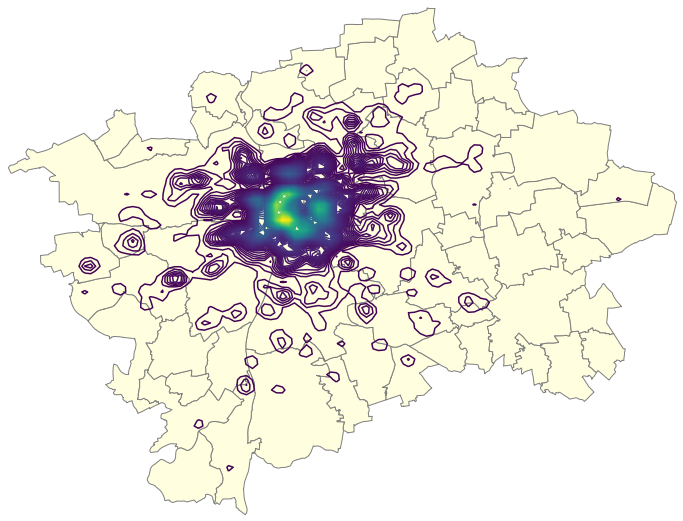

In [19]:
ax = gplt.polyplot(df_geo, 
                     projection=gcrs.AlbersEqualArea(),
                     edgecolor='grey', facecolor='lightyellow', linewidth=1, figsize=(12, 12))

gplt.kdeplot(points, n_levels=200, projection=gcrs.AlbersEqualArea(), extent = df_geo.total_bounds, ax = ax)
plt.show()

In [20]:
df_time_grouped = df_l.groupby('neighbourhood_cleansed')['centre_transit_time'].mean().reset_index()
df_time_grouped.columns = ['neighbourhood', 'centre_transit_time']

In [21]:
df_geo = df_geo.merge(df_time_grouped, on="neighbourhood", how = 'left')

/opt/conda/lib/python3.7/site-packages/geoplot/geoplot.py:625: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  extent = gpd.GeoSeries(self.extent) if self.extent is not None else None


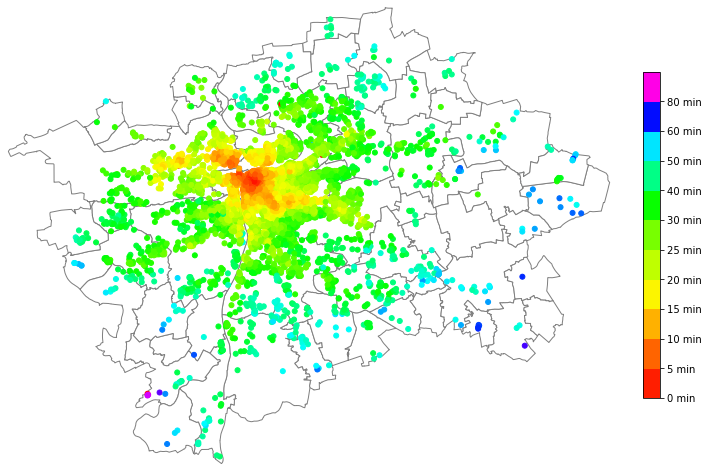

In [22]:
ax = gplt.polyplot(df_geo, 
                     projection=gcrs.AlbersEqualArea(),
                     edgecolor='grey', facecolor='white', linewidth=1, figsize=(12, 12))
gplt.pointplot(points, hue='centre_transit_time', 
               projection=gcrs.AlbersEqualArea(), 
               extent = df_geo.total_bounds, 
               cmap='hsv',
               legend = True,
               legend_kwargs= {'shrink': 0.5, 
                               'fraction': 0.05, 
                               'pad': 0.05,
                               'format': '%.0f min',
                               'ticks': [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80],
                               'boundaries': [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100]
                              },
               ax = ax)
ax.get_children()[-1].set_label('hey')
plt.show()

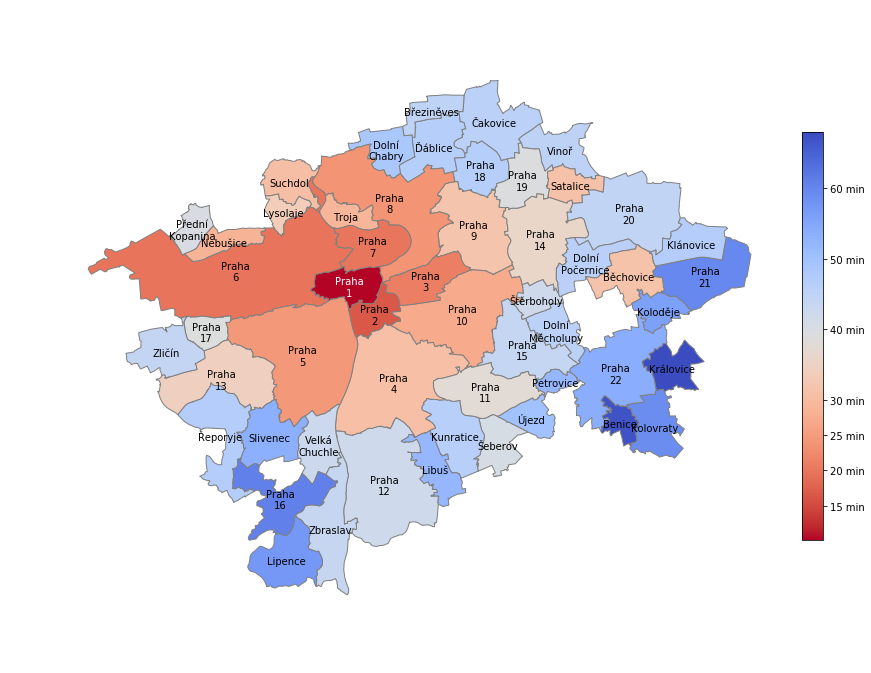

In [32]:
df_geo_nn = df_geo[df_geo['centre_transit_time'].notnull()]
ax = gplt.choropleth(df_geo_nn, 
                     projection=gcrs.EuroPP(),
                     hue = df_geo_nn['centre_transit_time'],
                     cmap = 'coolwarm_r',
                     edgecolor='grey', 
                     linewidth=1,
                     legend = True,
                     legend_kwargs= {'shrink': 0.5, 
                                     'fraction': 0.05, 
                                     'pad': -0.05,
                                     'format': '%.0f min',
                                     'ticks': [0, 1, 10, 15, 20, 25, 30, 40, 50, 60]},
                     figsize=(15, 15))
for i, item in df_geo.to_crs('EPSG:25832').centroid.iteritems():
    if not (np.isnan(df_geo.iloc[i]['centre_transit_time'])):
        ax.annotate(s=df_geo.iloc[i]['neighbourhood'].replace(' ', '\n'), 
                    xy=[item.x, item.y], 
                    color= 'black' if not (df_geo.iloc[i]['neighbourhood'] == 'Praha 1') else 'white', 
                    horizontalalignment='center',
                    verticalalignment='center')